
# Tackling mad-lib attacks in spam classification using BERT 

v1.0, Jun-2021 (c) Sergio A. Rojas-Galeano. 
Email: srojas@udistrital.edu.co

*NB: This NoteBook is released under the terms of the GNU General Public License (see license at: https://www.gnu.org/licenses/gpl-3.0.txt).
This software is made publicly available in the hope that it will be useful
to modelers, but WITHOUT ANY WARRANTY whatsoever.*

---

This a companion NoteBook to the paper "Tackling Mad-lib Spam Attacks using BERT Encoding". In that paper we investigated whether the BERT language model, may be useful to resist the synonym substitution adversarial attack (called “Mad-lib” as per the word substitution game) against spam classifiers. For this purpose we compared different document representation models (BoW, TFIDF and BERT) coupled with several classifiers (Decision Tree, kNN, SVM, Logistic Regression, Naive Bayes, Multilayer Perceptron), on th SMS spam collection dataset from the UCI repository.

# Initialisation and data loading

These are preliminary steps to setup the experimental testbed.




In [ ]:
## Install and import plotting libraries ##
!pip install scikit-plot
import scikitplot.plotters as skplt

## Install and import thesaurus libraries ##
!pip install PyDictionary
from PyDictionary import PyDictionary

## Install and import BERT libraries ##
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

print("\n\n Installation done!")


  Created wheel for goslate: filename=goslate-1.5.1-cp37-none-any.whl size=11376 sha256=bf6576c4d03771b7feb904140b5c105948f0a4ac221eb18cdd34ad5c9cef0649
  Stored in directory: /root/.cache/pip/wheels/4f/7f/28/6f52271012a7649b54b1a7adaae329b4246bbbf9d1e4f6e51a
Successfully built goslate
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 2.3MB 43.0MB/s 
     |████████████████████████████████| 1.2MB 48.8MB/s 
     |████████████████████████████████| 3.3MB 46.9MB/s 
     |████████████████████████████████| 901kB 39.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=780771ddbc767598300a448279ebea9ef616bee5b3f5462a1f1c5883cf8d1170
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers


 Installation done!


In [ ]:
## Import pre-installed libraries ##
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option('display.max_colwidth', None)

import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation

from pprint import pprint; 
import pickle

print("\n\n Libraries loaded!")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


 Libraries loaded!


In [ ]:
## Open data connection to Drive ##
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Dataset size:  (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Ã¥Â£1.50 to rcv"
6,ham,Even my brother is not like to speak with me. They treat me like aids patent.
7,ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8,spam,WINNER!! As a valued network customer you have been selected to receivea Ã¥Â£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
9,spam,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


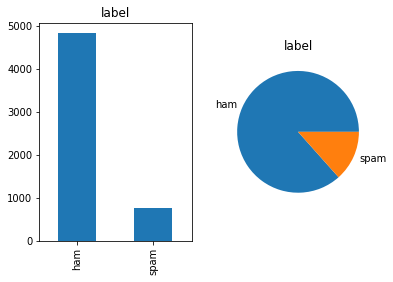

In [ ]:
## Load file into data frame ##
df = pd.read_csv('gdrive/My Drive/Colab Notebooks/data/spam/spam.csv', skiprows=1, names=['label', 'message'], encoding="ISO-8859-1")

## Display some statistics: histogram of text labels ##
_, ax = plt.subplots(1,2)
df['label'].value_counts().plot(ax=ax[0], kind="bar", rot=90, title='label');
df['label'].value_counts().plot(ax=ax[1], kind="pie", rot=90, title='label', ylabel='');
print("Dataset size: ", df.shape)

df.head(10)


# NLP setup

Here we defined functions for text pre-processing and cleanup.

In [ ]:
## Create some ancilliary functions to preprocess spanish words ##
stemmer = SnowballStemmer('english')

def stem_tokens(tokens, stemmer):
    stems = []
    for token in tokens:
        stems.append(stemmer.stem(token))
    return stems

def tokenize(text):
    text = ''.join([s for s in text if s not in non_words])
    tokens = word_tokenize(text)
    return tokens

def tokenize_stem(text):
    text = ''.join([s for s in text if s not in non_words])
    tokens = word_tokenize(text)
    tokens = stem_tokens(tokens, stemmer)
    return tokens

## Prepare non-words (punctuation) list ##
non_words = list(punctuation)
non_words.extend(map(str,range(10)))
print("Symbols to be removed (%d):" % len(non_words), non_words)

## Prepare english stopwords list ##
english_stopwords = stopwords.words('english')
print("Stop-words to be removed (%d):" % len(english_stopwords), english_stopwords)

Symbols to be removed (42): ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Stop-words to be removed (179): ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up',

# Build or load thesaurus

In order to perform the Mad-lib attacks automatically, we need a thesaurus. Thus, we extracted a vocabulary of the 5000 most frequent terms from the entire dataset and used them as keywords in a thesaurus. For each keyword, a list of synonyms is automatically scrapped from the pages of the website www.dictionary.com.

Notice that some text sequences (either proper words or gibberish) may not have synonyms found on the website. 

In [ ]:
## Setup a BoW instance and thesaurus ##
bow = CountVectorizer(
                analyzer = 'word',
                # ngram_range = (1, 2),
                strip_accents = 'ascii',
                tokenizer = tokenize,
                lowercase = True,
                stop_words = english_stopwords,
                max_features = 10000,     # A large limit allows BoW to extract the entire vocabulary
                )

dictionary = PyDictionary()               # This is the web scrapping object

## Get full vocabulary list and obtain their synonyms by scrapping https://www.synonym.com ##
print("Building thesaurus...")
bow.fit_transform(df['message'])
vocab = bow.get_feature_names()   
# print(len(vocab))
# pprint(vocab)

thesaurus = defaultdict(set)      

for i, word in enumerate(vocab):
  synonyms = dictionary.synonym(word)
  if synonyms is not None:
    thesaurus[word] = synonyms
    print("%s ->" % word, thesaurus[word])

## Save to a file ##
file = 'gdrive/My Drive/Colab Notebooks/data/spam/synonyms-5000.pkl' 
f = open(file,"wb")
pickle.dump(thesaurus, f)
f.close()

print("Thesaurus done!")


Streaming output truncated to the last 5000 lines.
incorrect -> ['erroneous', 'false', 'correctness', 'rightness', 'wrong', 'improper', 'fallacious', 'mistaken', 'inaccurate']
increase -> ['spike', 'explode', 'mount', 'compound', 'heighten', 'shoot up', 'accrue', 'pullulate', 'swell', 'grow', 'conglomerate', 'rise', 'accumulate', 'revalue', 'cumulate', 'wax', 'apprize', 'gather', 'crescendo', 'pyramid', 'climb', 'widen', 'irrupt', 'intensify', 'deepen', 'pile up', 'change magnitude', 'amass', 'snowball', 'broaden', 'add', 'gain', 'full', 'add to', 'apprise', 'appreciate']
incredible -> ['marvelous', 'undreamt of', 'implausible', 'credibility', 'fabulous', 'unthinkable', 'undreamt', 'dumfounding', 'marvellous', 'dumbfounding', 'flimsy', 'undreamed', 'undreamed of', 'unimagined', 'improbable', 'credibleness', 'believability', 'unbelievable', 'astounding', 'incredulous', 'tall', 'unconvincing']
increments -> ['price increase', 'fare increase', 'salary increase', 'wage hike', 'cost increas

In [ ]:
len(thesaurus)


4999

In [ ]:
## Have a peek at the thesaurus ##
file = 'gdrive/My Drive/Colab Notebooks/data/spam/synonyms-5000.pkl' 
synonyms = pickle.load(open(file, "rb"))
pprint(synonyms)

Streaming output truncated to the last 5000 lines.
                      'cubby',
                      'anteroom',
                      'dining-room',
                      'front room',
                      'court',
                      'conference room',
                      'hall',
                      'taproom',
                      'kitchen',
                      'saloon',
                      'room light',
                      'closet',
                      'dinette',
                      'torture chamber',
                      'back room',
                      'john',
                      'coatroom',
                      'squad room',
                      'rotunda',
                      'waiting room',
                      'picture gallery',
                      'vestibule',
                      'left-luggage office',
                      'vestry',
                      'storage room',
                      'jail cell',
                      'rec room',
   

# Setup Bag of Words (BoW) encoders

Here we setup and try the BoW and TFIDF encoders from the sckit-learn library.


In [ ]:
## Create BoW encoders ##
bow = CountVectorizer(
                analyzer = 'word',
                # ngram_range = (1, 2),
                strip_accents = 'ascii',
                tokenizer = tokenize_stem,
                lowercase = True,
                stop_words = english_stopwords,
                max_features = 768,         # We set the same dim as BERT
                )
tfidf = TfidfVectorizer(
                analyzer = 'word',
                # ngram_range = (2, 2),
                strip_accents = 'ascii',
                tokenizer = tokenize_stem,
                lowercase = True,
                stop_words = english_stopwords,
                max_features = 768,
                )

print("BoW setup done!")


BoW setup done!


In [ ]:
## Quick try of these encoders on a subset of messages ##
N_DOCS = 1000
bow_vecs = bow.fit_transform(df['message'][:N_DOCS])
tfidf_vecs = tfidf.fit_transform(df['message'][:N_DOCS])

df_bow = pd.DataFrame(data=bow_vecs.todense(), columns=bow.get_feature_names())
df_tfidf = pd.DataFrame(data=tfidf_vecs.todense(), columns=tfidf.get_feature_names())
display(df_bow.head(), df_tfidf.head())
print("BoW data size: ", bow_vecs.shape)
print("TFiDF data size: ", tfidf_vecs.shape)
print("Vocabulary: ", bow.get_feature_names())


,aa,abiola,abl,abt,ac,account,activ,actual,address,admir,aft,afternoon,age,ago,ah,ahead,aight,almost,alreadi,alright,also,alway,american,amp,ampm,angri,ani,announc,anoth,answer,anybodi,anymor,anyth,anytim,anyway,apart,apologis,appar,appli,ard,...,went,wer,whenev,whi,whole,wif,wil,win,wine,winner,wish,without,wk,wkli,wonder,wont,word,work,world,worri,worth,wot,would,wun,wwwldewcomwinppmxag,x,xmas,xxx,ya,yar,yeah,year,yes,yesterday,yet,yo,youll,youv,yr,yup
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,aa,abiola,abl,abt,ac,account,activ,actual,address,admir,aft,afternoon,age,ago,ah,ahead,aight,almost,alreadi,alright,also,alway,american,amp,ampm,angri,ani,announc,anoth,answer,anybodi,anymor,anyth,anytim,anyway,apart,apologis,appar,appli,ard,...,went,wer,whenev,whi,whole,wif,wil,win,wine,winner,wish,without,wk,wkli,wonder,wont,word,work,world,worri,worth,wot,would,wun,wwwldewcomwinppmxag,x,xmas,xxx,ya,yar,yeah,year,yes,yesterday,yet,yo,youll,youv,yr,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.288435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.561322,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.269375,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.257586,0.0,0.0,0.0,0.0,0.0,0.291468,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


BoW data size:  (1000, 768)
TFiDF data size:  (1000, 768)
Vocabulary:  ['aa', 'abiola', 'abl', 'abt', 'ac', 'account', 'activ', 'actual', 'address', 'admir', 'aft', 'afternoon', 'age', 'ago', 'ah', 'ahead', 'aight', 'almost', 'alreadi', 'alright', 'also', 'alway', 'american', 'amp', 'ampm', 'angri', 'ani', 'announc', 'anoth', 'answer', 'anybodi', 'anymor', 'anyth', 'anytim', 'anyway', 'apart', 'apologis', 'appar', 'appli', 'ard', 'around', 'ask', 'askd', 'avail', 'ave', 'await', 'award', 'away', 'awesom', 'b', 'babe', 'babi', 'back', 'bad', 'bank', 'bare', 'bath', 'batteri', 'bcoz', 'bday', 'beauti', 'becaus', 'bed', 'befor', 'begin', 'believ', 'best', 'better', 'big', 'birthday', 'bit', 'bite', 'blah', 'bless', 'blue', 'bonus', 'book', 'bore', 'boston', 'box', 'boy', 'boytoy', 'break', 'bring', 'britney', 'brother', 'bt', 'buffet', 'bus', 'busi', 'buy', 'c', 'call', 'caller', 'callertun', 'camcord', 'camera', 'cant', 'car', 'card', 'care', 'carlo', 'case', 'cash', 'catch', 'caus', 'cd

# Setup BERT encoders

Here we setup and try the BERT encoder from the sentence_transformers library.

In [ ]:
## Create BERT encoder ##
model = SentenceTransformer('xlm-r-bert-base-nli-stsb-mean-tokens')
print("\n\nBERT pre-trained model loaded!")




BERT pre-trained model loaded!


In [ ]:
## Ancilliary function to perform BERT encoding of a set of docs ##
def bert_transform(docs, encoder):    
  print("\n\nEncoding docs using BERT model: ")
  doc_vecs = []   
  for i, doc in enumerate(docs):
    doc_vec = encoder.encode(doc)
    doc_vecs.append(doc_vec)      
    print(".", end="" if (i%100>0) else ("%4d\n"%i))

  print("\nDocs embeddings ready!")
  return doc_vecs

print("BERT encoding function ready!")

BERT encoding function ready!


In [ ]:
## Ancilliary function to visualise the document encodings ##
def show_embeddings(doc_vecs):
  nreps = len(doc_vecs)
  fig, axs = plt.subplots(nrows=nreps, sharex=True, figsize = (16, 3*nreps))

  for i, key in enumerate(doc_vecs.keys()):
    enc_name = ("Encoding: %s") % key
    sns.heatmap(1-doc_vecs[key], cbar=False, ax=axs[i]).set_title(enc_name);


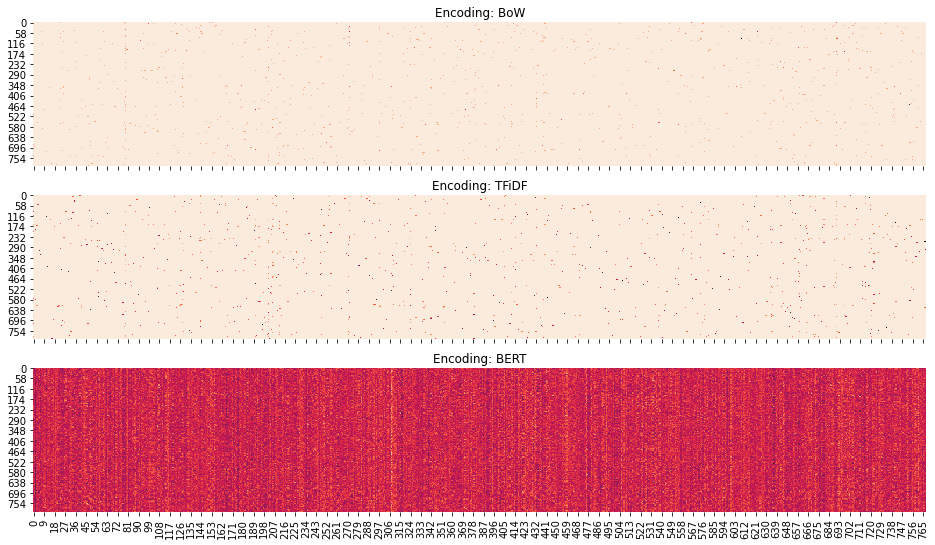

In [ ]:
  bert_vecs = bert_transform(df['message'][:N_DOCS], model)
  spam_vecs = defaultdict(list)
  spam_vecs["BoW"] = bow_vecs.todense().A
  spam_vecs["TFiDF"] = tfidf_vecs.todense().A
  spam_vecs["BERT"] = np.array(bert_vecs)
  
  # Display the vector representation of each message by the three encoders #
  # BoW and TFIDF yield sparse representations, whereas BERT yield dense    # 
  show_embeddings(spam_vecs)

# Setup classifiers

Now we set up the classification algorithms with the best set of parameters found in previous experiments. We also define train and test functions.

In [ ]:
classifiers = [
    KNeighborsClassifier(15),
    LogisticRegression(),
    LinearSVC(C=1, loss='squared_hinge', max_iter=1000, random_state=None, penalty='l2', tol=0.0001),
    SVC(gamma=.01, C=100),
    MLPClassifier(hidden_layer_sizes=(10,), alpha=1, max_iter=1000),
    DecisionTreeClassifier(max_depth=10),
    GaussianNB(),
    ]

print("Classifiers ready!")

Classifiers ready!


In [ ]:
## Ancilliary function to train and test a classifier ##
def train_test_clf(clf, X_train, y_train, X_test, y_test, tag="", viz=False):
  """
  Args:
      clf:     Classifier object
      X_train: Encoding vectors of training docs   
      y_train: Labels of training docs
      X_test:  Encoding vectors of test docs   
      y_test:  Labels of test docs        
  """
  ## Perform classification ##
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  ## Compute classification metrics ##
  acc = accuracy_score(y_test, y_pred)
  bacc = balanced_accuracy_score(y_test, y_pred)
  prec, sens, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='spam')

  ## Show results ##
  print('{:<36s} Balanced accuracy: {:.2f}%'.format(tag, bacc*100))
  if viz:
    skplt.plot_confusion_matrix(y_test, y_pred, title=tag+'BAcc: {0:.2f}%'.format(bacc*100), 
                              normalize=False, x_tick_rotation='vertical');
    plt.show()

  return acc, bacc, prec, sens, f1
      
print("Train/test function ready!")

Train/test function ready!


In [ ]:
## Ancilliary function to test a classifier ##
def test_clf(clf, X_test, y_test, tag="", viz=False):
  """
  Args:
      clf:     Pre-trained classifier object 
      X_test:  Encoding vectors of test docs   
      y_test:  Labels of test docs        
  """
  ## Perform classification ##
  y_pred = clf.predict(X_test)

  ## Compute classification metrics ##
  acc = accuracy_score(y_test, y_pred)
  bacc = balanced_accuracy_score(y_test, y_pred)
  prec, sens, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='spam')

  ## Show results ##
  print('{:<36s} Balanced accuracy: {:.2f}%'.format(tag, bacc*100))
  if viz:
    skplt.plot_confusion_matrix(y_test, y_pred, title=tag+'BAcc: {0:.2f}%'.format(bacc*100), 
                              normalize=False, x_tick_rotation='vertical');
    plt.show()

  return acc, bacc, prec, sens, f1

print("Test function ready!")

Test function ready!


# Down-stream spam classification experiments

The code in this section is used to conduct two experiments: 
* Spam classification of original messages
* Spam classification of modified messages with Mad-lib attack

In [ ]:
## Ancilliary function to split the dataset into development (80%) and holdout (20%) ##
def split_dataset(df, n_docs=100, viz=False):
  D_dev, D_hold, y_dev, y_hold = train_test_split(df['message'][:n_docs], 
                                                  df['label'][:n_docs], 
                                                  test_size=0.2, 
                                                  shuffle=True)
  ## Display data statistics ##
  if viz:
    _, ax = plt.subplots(1, 2)
    y_dev.value_counts().plot(ax=ax[0], kind='pie', figsize=(8, 8), 
                               autopct=lambda x: "%d" % round(y_dev.shape[0]*x/100), 
                               ylabel='', title='Development')
    y_hold.value_counts().plot(ax=ax[1], kind='pie', figsize=(8, 8), 
                               autopct=lambda x: "%d" % round(y_hold.shape[0]*x/100), 
                               ylabel='', title='Hold-out')
    plt.show()
    display("Dev split contents:", D_dev.to_frame().head(5))
    display("Hold-out split contents:", D_hold.to_frame().head(5))
    print("Dev split size (docs/labels): ", D_dev.shape, y_dev.shape)
    print("Hold-out split size (docs/labels): ", D_hold.shape, y_hold.shape)

  return D_dev, D_hold, y_dev, y_hold

print("Split function ready!")

Split function ready!


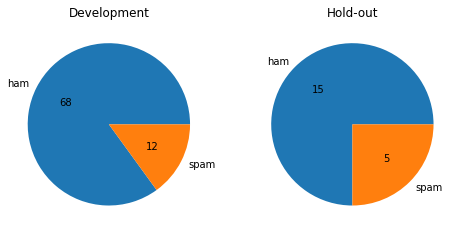

'Dev split contents:'

,message
76,Thats cool. i am a gentleman and will treat you with dignity and respect.
92,Smile in Pleasure Smile in Pain Smile when trouble pours like Rain Smile when sum1 Hurts U Smile becoz SOMEONE still Loves to see u Smiling!!
31,Yeah he got in at 2 and was v apologetic. n had fallen out and she was actin like spoilt child and he got caught up in that. Till 2! But we won't go there! Not doing too badly cheers. You?
26,Lol your always so convincing.
17,Eh u remember how 2 spell his name... Yes i did. He v naughty make until i v wet.


'Hold-out split contents:'

,message
56,"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!"
5,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Ã¥Â£1.50 to rcv"
64,Ok lar i double check wif da hair dresser already he said wun cut v short. He said will cut until i look nice.
6,Even my brother is not like to speak with me. They treat me like aids patent.
45,No calls..messages..missed calls


Dev split size (docs/labels):  (80,) (80,)
Hold-out split size (docs/labels):  (20,) (20,)


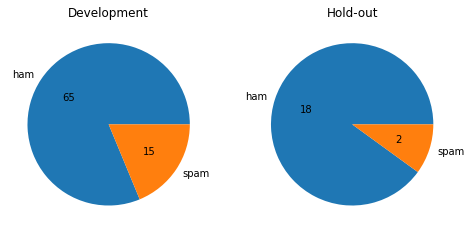

'Dev split contents:'

,message
64,Ok lar i double check wif da hair dresser already he said wun cut v short. He said will cut until i look nice.
3,U dun say so early hor... U c already then say...
29,Ahhh. Work. I vaguely remember that! What does it feel like? Lol
4,"Nah I don't think he goes to usf, he lives around here though"
31,Yeah he got in at 2 and was v apologetic. n had fallen out and she was actin like spoilt child and he got caught up in that. Till 2! But we won't go there! Not doing too badly cheers. You?


'Hold-out split contents:'

,message
82,Ok i am on the way to home hi hi
22,So Ã_ pay first lar... Then when is da stock comin...
7,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
56,"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!"
55,Do you know what Mallika Sherawat did yesterday? Find out now @ &lt;URL&gt;


Dev split size (docs/labels):  (80,) (80,)
Hold-out split size (docs/labels):  (20,) (20,)


In [ ]:
## Try some splits #
split_dataset(df, viz=True);
split_dataset(df, viz=True);

In [ ]:
import re

## Set number of documents to process ##
# N_DOCS = 1000
N_DOCS = df.shape[0]
N_REPS = 30
N_SUBS = 10
print("Number of documents to process: ", N_DOCS)
print("Number of replicates: ", N_REPS)

## Load thesaurus ##
thesfile = 'gdrive/My Drive/Colab Notebooks/data/spam/synonyms-5000.pkl' 
thesaurus = pickle.load(open(thesfile, "rb"))

## Initialize results holders ##
np.random.seed(seed=20212021)     # Seed is fixed to ensure reproducibility

results1 = pd.DataFrame(columns=['Rep', 'Encoder', 'Classifier', 'Acc', 
                                 'BAcc', 'Prec', 'Sens', 'F1'])
results2 = pd.DataFrame(columns=['Rep', 'Subs', 'True_subs', 'Encoder', 
                                 'Classifier', 'Acc', 
                                 'BAcc', 'Prec', 'Sens', 'F1'])

for i_rep in range(N_REPS):

  ###########################################################################
  ############## Spam classification experiments (D_dev split) ##############
  ###########################################################################
  print("\n\n------ Replicate: %d ------" % (i_rep+1))
  D_dev, D_hold, y_dev, y_hold = split_dataset(df, N_DOCS, viz=False)

  ## Obtain BoW spam message encodings ##
  bow_vecs = bow.fit_transform(D_dev)
  tfidf_vecs = tfidf.fit_transform(D_dev)
  print("\n\nComputing BoW encoding... done!")

  ## Obtain BERT spam message encodings ##
  bert_vecs = bert_transform(D_dev, model)
  print("BERT encoding done!\n")

  spam_vecs = defaultdict(list)
  spam_vecs["BoW"] = bow_vecs.todense().A
  spam_vecs["TFiDF"] = tfidf_vecs.todense().A
  spam_vecs["BERT"] = np.array(bert_vecs)

  ## Try the set of classifiers on each encoding ##
  for key in spam_vecs.keys():
    X_train, X_test, y_train, y_test = train_test_split(spam_vecs[key], y_dev, 
                                                        test_size=0.25)
    for clf in classifiers:
      acc, bacc, prec, sens, f1 = train_test_clf(clf, X_train, y_train, X_test, y_test, 
                             "[%s %s] " % (key, type(clf).__name__), viz=False)
      ## Record results ##
      results1 = results1.append({'Rep': i_rep, 'Encoder': key, 
                                  'Classifier': type(clf).__name__, 
                                  'Acc': acc, 'BAcc': bacc, 
                                  'Prec': prec, 'Sens': sens,
                                  'F1': f1}, ignore_index=True)

  ###########################################################################
  ############# Attack classification experiments (D_hold split) ############
  ###########################################################################
  for i_sub in [0, 5, 10]: #range(N_SUBS):
    print("\n\n------ Rep: %d, Substitutions: %d ------" % (i_rep, i_sub))

    ## Firstly, build the modified (attacked) dataset with substitutions ##
    D_attack = []; subs_count = []
    for doc in D_hold:
      print("\nOriginal: " + doc)
      doc = re.sub('[^a-zA-Z0-9_]', ' ', doc)
      words = doc.lower().split(" ")
      n_words = len(words)
      idx = np.random.choice(n_words, size=min(i_sub, n_words), replace=False)
      print(idx)
      count = 0
      for i in idx:
        synonyms = thesaurus[words[i]]
        if synonyms:
          substitute = np.random.choice(synonyms) 
          print(words[i], "-->", substitute)  
          words[i] = substitute
          count += 1
        else:
          print("Not synonyms found for word: %s" % words[i])
      doc = " ".join(words)
      print("Attacked (%i subs): %s" % (count, doc))
      D_attack.append(doc)
      subs_count.append(count)
      
    ## Now obtain BoW attacked message encodings (with pretrained BoW) ##
    bow_vecs = bow.transform(D_attack)
    tfidf_vecs = tfidf.transform(D_attack)
    print("\n\nComputing BoW encoding... done!")

    ## Now obtain BERT attacked message encodings ##
    bert_vecs = bert_transform(D_attack, model)
    print("BERT encoding done!\n")

    attack_vecs = defaultdict(list)
    attack_vecs["BoW"] = bow_vecs.todense().A
    attack_vecs["TFiDF"] = tfidf_vecs.todense().A
    attack_vecs["BERT"] = np.array(bert_vecs)

    ## Lastly, try the set of classifiers on each encoding ##
    for key in attack_vecs.keys():
      for clf in classifiers:
        acc, bacc, prec, sens, f1 = test_clf(clf, attack_vecs[key], y_hold, 
                              "[%s %s] " % (key, type(clf).__name__), viz=False)
        ## Record results ##
        results2 = results2.append({'Rep': i_rep, 'Subs': i_sub, 
                                    'True_subs': np.mean(subs_count),
                                    'Encoder': key, 
                                    'Classifier': type(clf).__name__, 
                                    'Acc': acc, 'BAcc': bacc, 
                                    'Prec': prec, 'Sens': sens,
                                    'F1': f1}, ignore_index=True)

## Store results ##
pprint(results1)
file = 'gdrive/My Drive/Colab Notebooks/data/spam/clf-results1.pkl' 
f = open(file,"wb")
pickle.dump(results1, f)
f.close()

pprint(results2)
file = 'gdrive/My Drive/Colab Notebooks/data/spam/clf-results2.pkl' 
f = open(file,"wb")
pickle.dump(results2, f)
f.close()

print("Done!")

Streaming output truncated to the last 5000 lines.
oni --> USN
go --> rush along
b --> eubacterium
Not synonyms found for word: i
Not synonyms found for word: 
Attacked (6 subs): dunno lei shd eubacterium dynamical lor cos lettuce i rush along sch 1 minute USN 

Original: Wat u doing there?
[3 4 0 2 1]
Not synonyms found for word: there
Not synonyms found for word: 
Not synonyms found for word: wat
Not synonyms found for word: doing
u --> upper-class
Attacked (1 subs): wat upper-class doing there 

Original: Wat's da model num of ur phone?
[2 3 0 4 5 1 6 7 8]
da --> prosecuting attorney
model --> theory
Not synonyms found for word: wat
Not synonyms found for word: num
Not synonyms found for word: of
Not synonyms found for word: s
ur --> Sumer
phone --> receiver
Not synonyms found for word: 
Attacked (4 subs): wat s prosecuting attorney theory num of Sumer receiver 

Original: Please call our customer service representative on 0800 169 6031 between 10am-9pm as you have WON a guaranteed 

# Results summary

In [ ]:
## Summarise the results of the original spam classification ##
file = 'gdrive/My Drive/Colab Notebooks/data/spam/clf-results1.pkl' 
results = pickle.load(open(file, "rb"))

pd.options.display.float_format = '{:,.1%}'.format
pd.options.display.max_rows = None

print("\n\n>>>>> Classification experiments: ", results.shape)

# Display general statistics #
display(results.groupby(['Encoder']).describe())

aggregations = {
  'BAcc': [lambda x: "%.1f+-%.1f%%" % (np.mean(x)*100, np.std(x)*100)],
  'Acc' : [lambda x: "%.1f+-%.1f%%" % (np.mean(x)*100, np.std(x)*100)],
  'Sens': [lambda x: "%.1f+-%.1f%%" % (np.mean(x)*100, np.std(x)*100)],
  'Prec': [lambda x: "%.1f+-%.1f%%" % (np.mean(x)*100, np.std(x)*100)],
  # 'Sens': [np.mean, np.std, min],
}

# Display aggregated statistics by encoder and classifier #
display(results.groupby(['Encoder','Classifier']).agg(aggregations))





>>>>> Classification experiments:  (630, 8)


Acc                         ...    F1                        
            count  mean  std   min   25%  ...   min   25%   50%   75%   max
Encoder                                   ...                              
BERT    21,000.0% 97.2% 2.0% 90.9% 96.1%  ... 69.8% 86.2% 93.3% 95.1% 97.8%
BoW     21,000.0% 93.1% 7.4% 73.0% 89.8%  ... 20.4% 53.1% 88.7% 91.1% 94.4%
TFiDF   21,000.0% 92.9% 7.0% 74.3% 88.8%  ... 10.5% 53.5% 84.0% 90.2% 96.2%

[3 rows x 40 columns]

BAcc         Acc        Sens        Prec
                                  <lambda>    <lambda>    <lambda>    <lambda>
Encoder Classifier                                                            
BERT    DecisionTreeClassifier  85.2+-1.7%  93.3+-0.9%  73.9+-3.1%  76.6+-4.1%
        GaussianNB              93.1+-1.0%  95.8+-0.5%  89.3+-2.0%  82.0+-3.2%
        KNeighborsClassifier    93.2+-1.3%  97.0+-0.5%  87.9+-2.7%  89.8+-2.4%
        LinearSVC               96.3+-0.9%  98.4+-0.3%  93.2+-1.8%  95.3+-1.9%
        LogisticRegression      96.3+-0.9%  98.7+-0.3%  93.0+-1.8%  97.5+-1.3%
        MLPClassifier           96.6+-0.9%  98.8+-0.3%  93.5+-1.8%  97.4+-1.3%
        SVC                     95.1+-1.1%  98.6+-0.4%  90.3+-2.2%  99.4+-0.9%
BoW     DecisionTreeClassifier  84.1+-1.8%  95.0+-0.5%  69.3+-3.8%  91.3+-3.2%
        GaussianNB              82.6+-1.2%  76.4+-1.5%  91.0+-2.2%  35.1+-2.7%
        KNeighborsClassifier    59.8+-1.7%  89.3+-0.8%  19.7+-3.4%  99.5+-1.7%
        LinearSVC               93.8+-1.2%  97.7+-0.3%  88.6+-2.5%  93.3+-1.5%
        LogisticRegression      92.8+-1.4%  97.9+-0.4%  85.9+-2.7%  97.8+-1.4%
        MLPClassifier           92.2+-1.3%  97.7+-0.4%  84.7+-2.6%  97.8+-1.5%
        SVC                     93.6+-1.4%  97.5+-0.4%  88.3+-2.8%  92.6+-2.0%
TFiDF   DecisionTreeClassifier  86.0+-2.0%  94.9+-0.6%  73.8+-4.3%  86.1+-3.6%
        GaussianNB              82.8+-1.0%  77.9+-1.5%  89.6+-2.5%  36.4+-2.4%
        KNeighborsClassifier    55.4+-1.1%  88.2+-1.0%  10.8+-2.2%  99.4+-1.9%
        LinearSVC               94.0+-1.4%  98.1+-0.5%  88.5+-2.8%  96.6+-2.0%
        LogisticRegression      87.3+-1.6%  96.5+-0.5%  74.9+-3.1%  98.0+-1.4%
        MLPClassifier           88.0+-1.5%  96.6+-0.5%  76.2+-3.1%  97.9+-1.3%
        SVC                     93.9+-1.4%  98.0+-0.4%  88.4+-2.9%  96.3+-1.8%

In [ ]:
## Summarise the results of the mad-lib spam attack classification ##

file = 'gdrive/My Drive/Colab Notebooks/data/spam/clf-results2.pkl' 
results = pickle.load(open(file, "rb"))
print("\n\n>>>>> Attack experiments: ", results.shape)

# Display general statistics #
display(results.groupby(['Encoder']).describe())

aggregations = {
  'True_subs': [lambda x: "%.2f" % np.mean(x)],
  'BAcc': [lambda x: "%.1f+-%.1f%%" % (np.mean(x)*100, np.std(x)*100)],
  'Acc' : [lambda x: "%.1f+-%.1f%%" % (np.mean(x)*100, np.std(x)*100)],
  'Sens': [lambda x: "%.1f+-%.1f%%" % (np.mean(x)*100, np.std(x)*100)],
  'Prec': [lambda x: "%.1f+-%.1f%%" % (np.mean(x)*100, np.std(x)*100)],
        # 'F1': [np.mean, np.std, min],
}

# Display aggregated statistics by encoder with SVM Linear classifier fixed #
display(results.query("Classifier == 'LinearSVC'").groupby(['Subs','Encoder']).agg(aggregations))




>>>>> Attack experiments:  (1890, 10)


True_subs                          ...    F1                        
            count   mean    std  min  25%  ...   min   25%   50%   75%   max
Encoder                                    ...                              
BERT    63,000.0% 172.0% 136.7% 0.0% 0.0%  ... 56.1% 81.7% 90.7% 93.8% 97.7%
BoW     63,000.0% 172.0% 136.7% 0.0% 0.0%  ...  0.0%  0.0%  0.0%  4.4% 41.7%
TFiDF   63,000.0% 172.0% 136.7% 0.0% 0.0%  ...  0.0%  0.0%  0.0%  0.0% 27.3%

[3 rows x 48 columns]

True_subs        BAcc         Acc        Sens         Prec
              <lambda>    <lambda>    <lambda>    <lambda>     <lambda>
Subs Encoder                                                           
0    BERT         0.00  96.6+-0.9%  98.3+-0.4%  94.4+-1.9%   92.8+-2.3%
     BoW          0.00  54.9+-3.8%  79.4+-2.5%  21.5+-8.0%   21.7+-6.5%
     TFiDF        0.00  50.0+-0.3%  86.6+-0.8%   0.3+-0.6%  13.7+-28.4%
5    BERT         1.82  96.2+-1.0%  97.6+-0.5%  94.2+-2.0%   88.4+-3.1%
     BoW          1.82  55.2+-3.7%  80.7+-2.2%  20.4+-7.7%   23.4+-7.0%
     TFiDF        1.82  50.0+-0.3%  86.6+-0.7%   0.3+-0.6%  15.4+-29.1%
10   BERT         3.34  95.2+-0.9%  96.8+-0.6%  93.0+-1.7%   84.8+-2.8%
     BoW          3.34  55.2+-3.3%  82.1+-2.1%  18.7+-6.8%   25.8+-7.8%
     TFiDF        3.34  50.0+-0.2%  86.6+-0.7%   0.2+-0.4%  13.8+-30.2%

# Conclusion

The results provide empirical evidence suggesting BERT encodings are able to resist the Mad-lib spam attack, whereas BoW and TDIDF detection rates drop dramatically. On the computational side, BERT is heavier than the simpler BoW encoders which nonetheless, are able to achieve comparable performances with spam not tampered with by Mad-lib adversaries. 

---
**END OF NOTEBOOK**
